
# Phase C – Mini Mazeworld Demo

This notebook demonstrates **Phase C (Credit Markets)** on a tiny, intentionally boring
Mazeworld. The goal is *not* to solve the maze, but to make **sediment** and **inhibition**
visible via capital flows.

**What to expect**
- No learning inside explorers (pure random walk)
- All structure emerges from the Broker (Inhibitor)
- Capital concentrates; others are gated
- The plots should feel *unspectacular*


In [13]:

# Imports
import numpy as np
import matplotlib.pyplot as plt

from capitalmarket.capitalselector.broker import Broker, BrokerConfig
from capitalmarket.capitalselector.channels import GaussianExplorer
from capitalmarket.capitalselector.core import CapitalSelector



## Mini Mazeworld Channel

A random walk on a small grid with sparse rewards.
No semantics leak out: only (r, c, alive, dt).


In [14]:

class MiniMazeChannel:
    def __init__(self, size=7, reward_cells={(6,6): 5.0}, step_cost=0.05, seed=0):
        self.rng = np.random.default_rng(seed)
        self.size = size
        self.reward_cells = reward_cells
        self.step_cost = step_cost
        self.pos = (0,0)

    def step(self, weight: float):
        if weight <= 0:
            return 0.0, 0.0, True, 1.0

        x,y = self.pos
        dx,dy = self.rng.choice([(1,0),(-1,0),(0,1),(0,-1)])
        nx,ny = max(0,min(self.size-1,x+dx)), max(0,min(self.size-1,y+dy))
        self.pos = (nx,ny)

        r = self.reward_cells.get(self.pos, 0.0)
        c = self.step_cost * weight
        return r, c, True, 1.0



## Setup


In [15]:
# Define explorers, broker, selector, and history
explorers = {
    "E1": MiniMazeChannel(seed=1),
    "E2": MiniMazeChannel(seed=2),
    "E3": MiniMazeChannel(seed=3),
}
ids = list(explorers.keys())

broker = Broker(BrokerConfig())
selector = (
    CapitalSelectorBuilder()
    .with_K(len(ids))
    .with_initial_wealth(1.0)
    .with_rebirth_threshold(-1e9)
    .build()
)

capital_hist = {k: [] for k in ids}
T = 400

In [16]:
# Imports from local package (prefer simple local folder import)
try:
    from capitalselector import Broker, BrokerConfig, CapitalSelectorBuilder
except ModuleNotFoundError:
    # Fallback if project is added as parent package 'capitalmarket'
    from capitalmarket.capitalselector import Broker, BrokerConfig, CapitalSelectorBuilder

# MiniMazeChannel is defined above in this notebook.


## Event Loop


In [17]:
# Phase-C event loop with Broker gating and vector feedback
for t in range(T):
    # Raw allocation from selector
    w_raw = selector.allocate()
    raw = {eid: float(w_raw[i]) for i, eid in enumerate(ids)}

    # Apply inhibition policies and optional de-correlation
    w = broker.apply_policies(raw)

    # Step eligible explorers and collect feedback
    r_vec = np.zeros(len(ids), dtype=float)
    c_total = 0.0
    for i, eid in enumerate(ids):
        wi = w.get(eid, 0.0)
        if wi <= 0.0:
            continue
        r, c, alive, dt = explorers[eid].step(wi)
        broker.observe(eid, r, c, alive, dt)
        r_vec[i] = float(r)
      
        c_total += float(c)

    # Update selector with vectorized returns
    selector.feedback_vector(r_vec, c_total)

    # Record capital weights (post-policy)
    for k in ids:
        capital_hist[k].append(w.get(k, 0.0))


## Plots – Sediment as Capital Flow


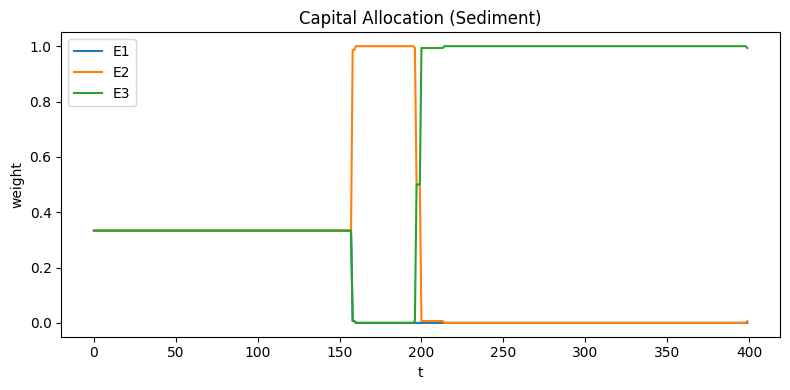

In [18]:

plt.figure(figsize=(8,4))
for k,v in capital_hist.items():
    plt.plot(v, label=k)
plt.title("Capital Allocation (Sediment)")
plt.xlabel("t")
plt.ylabel("weight")
plt.legend()
plt.tight_layout()
plt.show()
